# Simulating hard spheres with Monte Carlo

Notebook written by [Manon Michel](manon.michel@uca.fr)

The goal here is to sample hard spheres systems. 

Hard spheres interact through an exclusion force, meaning that they cannot overlap. For a given diameter $\sigma>0$, the stationary probability distribution for of $N$ spheres in dimension $d$ in a square box of size $L$ with periodic boundaries has density with respect to the Lebesgue measure given by  $$\pi(x) = \prod_{i=1}^n\left( \prod_{k=1}^d\mathbb{1}(x_{i,k} >0)\mathbb{1}(x_{i,k} - L <0)\prod_{j<i} \mathbb{1}(||x_i-x_j||_2 - \sigma > 0) \right) \, .$$
Here $x \in \mathbb{R}^{d\times N}$ is a configuration of $N$ spheres at coordinates $x_i \in \mathbb{R}^d$ with $i \in \{1,\ldots,N\}$.

In [9]:
import numpy as np
import random, math
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 8

## 1) Two schemes for rejection sampling

We set $d=2$, $N=4$, $\sigma=1$ and $L=16$. 

> 1. Use the following code to generate 10000 configurations with both reject-sampling routines.
> 2. Plot the histograms of the interdistance between spheres (one plot) and of the x-coordinate and y-coordinate of the sphere positions (another plot) and compare both algorithms.
> 3. Plot the cumulative histograms of the interdistance between spheres (one plot) and of the x-coordinate and y-coordinate of the sphere positions (another plot) and compare both algorithms.

In [10]:
class periodic_hard_sphere:
    def __init__(self,N=4, d=2, sigma=1.0, L = 16):
        # Parameter initialization
        self.N = N #number of spheres
        self.d = d #dimension of box
        self.sigma = sigma #sphere diameter
        self.L = L #length of square box
    
    def get_periodic_distance(self, x_1,x_2):        
        delta_x = x_1-x_2
        diff_x_periodic = min(abs(delta_x[0]),self.L-abs(delta_x[0]))
        diff_y_periodic = min(abs(delta_x[1]),self.L-abs(delta_x[1]))
        d_sq = diff_x_periodic ** 2.0 + diff_y_periodic ** 2.0
        return d_sq**0.5
    
    def pair_overlap_check(self,x_1, x_2):
        d = self.get_periodic_distance(x_1,x_2)
        if d < self.sigma:
            return True  #There is an overlap          
        return False
    
    def generate_sphere_position(self):
        x_i_new = self.L * np.random.uniform(size=2) 
        return x_i_new
        
    def rejection_sampling_1(self):
        x = []
        while len(x) < self.N:
            overlapping_proposition = True
            while overlapping_proposition:
                x_i_new = self.generate_sphere_position()
                overlapping_proposition = False
                for x_j in x:
                    if self.pair_overlap_check(x_j,x_i_new):
                        overlapping_proposition = True
                        break
            x += [x_i_new]
        return x
    
       
    def rejection_sampling_2(self):                    
        x = []
        while  len(x) < self.N:
            while len(x) < self.N:
                x_i_new = self.generate_sphere_position()
                overlapping_proposition = False
                for x_j in x:
                    if self.pair_overlap_check(x_j,x_i_new):
                        overlapping_proposition = True
                        break
                if overlapping_proposition:
                    x = []
                    break
                x += [x_i_new]
        return x    
   

Exercise 1:


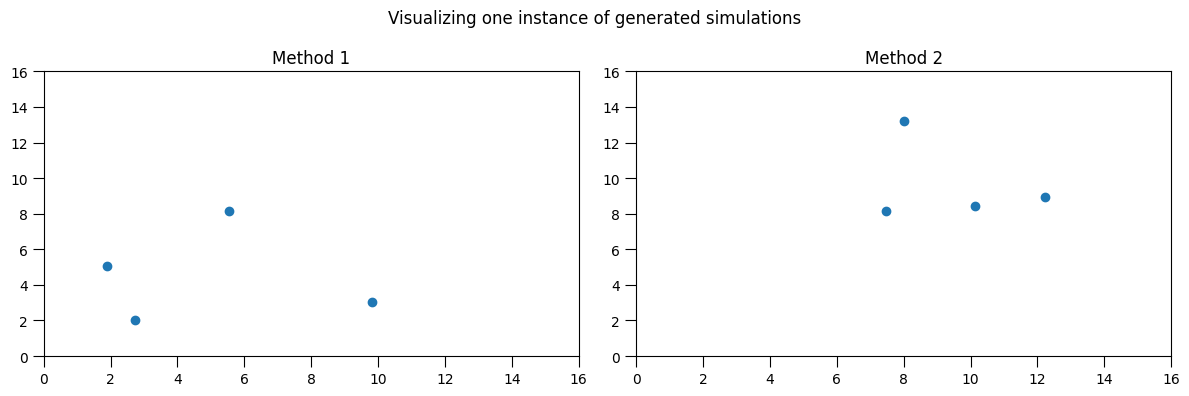

Exercise 2:


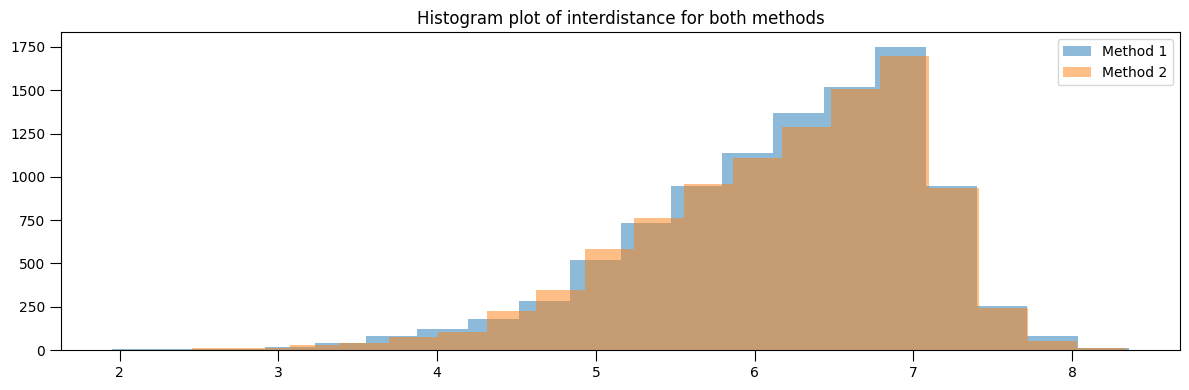

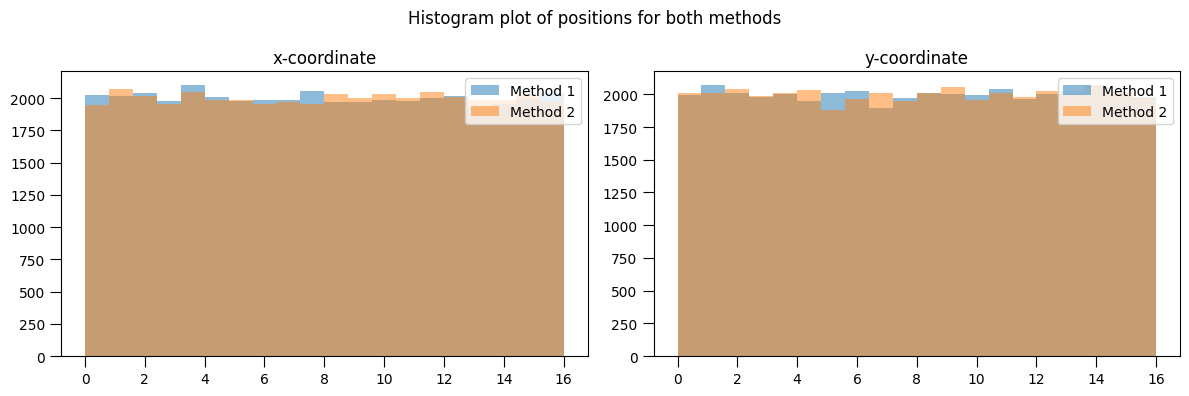

Exercise 3:


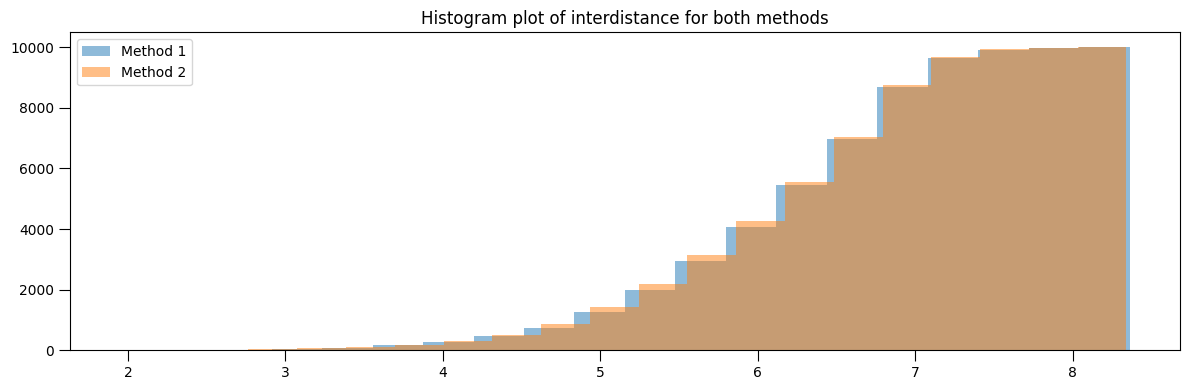

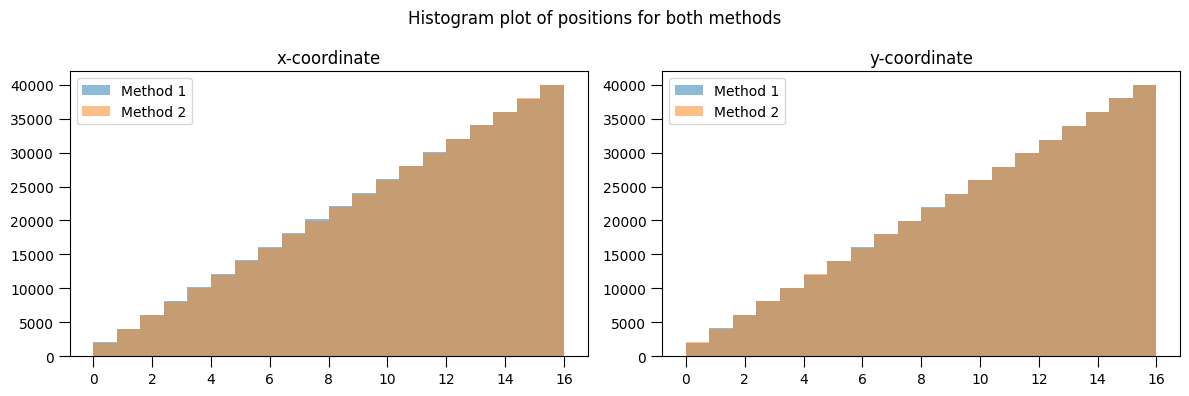

Extra plots


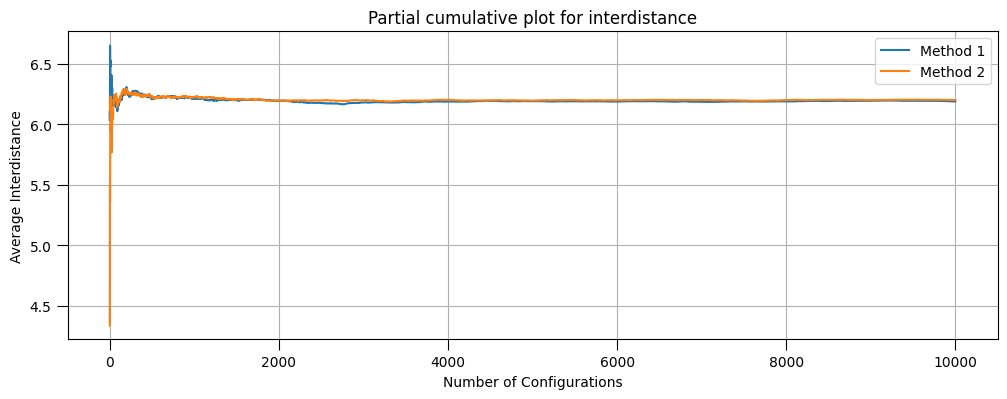

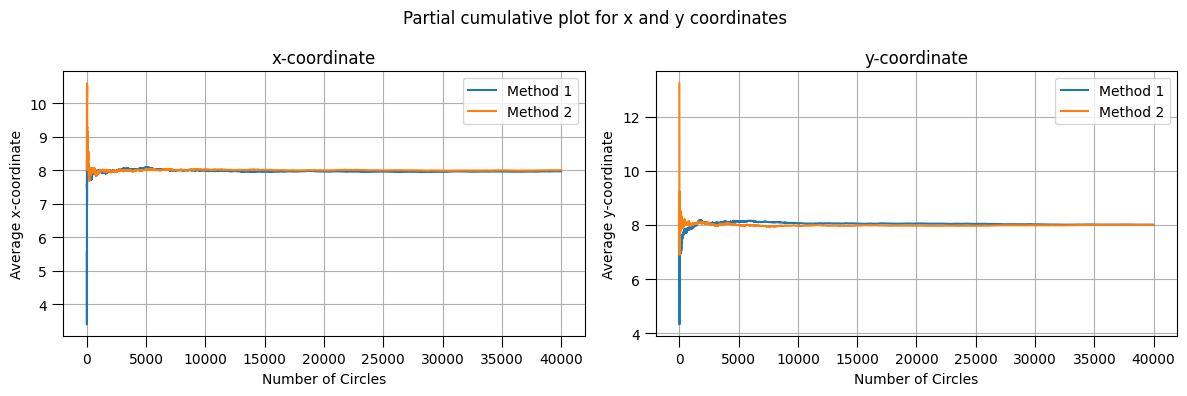

In [13]:
M = 10000
N = 4
d = 2

sigma = 1
L = 16

simulation = periodic_hard_sphere(N,d,sigma,L)

## Exercise 1
print("Exercise 1:")
# Generating configurations
configurations1 = np.zeros((M,N,d))
interdistance1 = np.zeros(M)

configurations2 = np.zeros((M,N,d))
interdistance2 = np.zeros(M)

for i in range(M):
    # Generating positions
    configurations1[i,:,:] = np.array(simulation.rejection_sampling_1())
    configurations2[i,:,:] = np.array(simulation.rejection_sampling_2())
    # Getting interdistances

    for j in range(N):
        for k in range(j):
            interdistance1[i] += simulation.get_periodic_distance(configurations1[i,j,:], configurations1[i,k,:])
            interdistance2[i] += simulation.get_periodic_distance(configurations2[i,j,:], configurations2[i,k,:])

    interdistance1[i] /= N * (N-1) / 2
    interdistance2[i] /= N * (N-1) / 2
    
# Visualizing one simulation
plt.figure(figsize=(12,4))
plt.suptitle("Visualizing one instance of generated simulations")

plt.subplot(1,2,1)
plt.title("Method 1")
x = configurations1[0,:,0]
y = configurations1[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.subplot(1,2,2)
plt.title("Method 2")
x = configurations2[0,:,0]
y = configurations2[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.tight_layout()
plt.show()

## Exercise 2
print("Exercise 2:")

# Histogram plot of interdistance for both methods
plt.figure(figsize=(12,4))
plt.title("Histogram plot of interdistance for both methods")
plt.hist(interdistance1, label='Method 1', alpha = 0.5, bins = 20)
plt.hist(interdistance2, label='Method 2', alpha = 0.5, bins = 20)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram plot for x and y coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot of positions for both methods")

# x-coordinate
plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.hist(configurations1[:,:,0].flatten(), alpha = 0.5, label='Method 1', bins = 20)
plt.hist(configurations2[:,:,0].flatten(), alpha = 0.5, label='Method 2', bins = 20)
plt.legend()

# y-coordinate
plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.hist(configurations1[:,:,1].flatten(), alpha = 0.5, label='Method 1', bins = 20)
plt.hist(configurations2[:,:,1].flatten(), alpha = 0.5, label='Method 2', bins = 20)
plt.legend()

plt.tight_layout()
plt.show()

## Exercise 3
print("Exercise 3:")


# Histogram plot of interdistance for both methods
plt.figure(figsize=(12,4))
plt.title("Histogram plot of interdistance for both methods")
plt.hist(interdistance1, label='Method 1', alpha = 0.5, bins = 20, cumulative=True)
plt.hist(interdistance2, label='Method 2', alpha = 0.5, bins = 20, cumulative=True)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram plot for x and y coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot of positions for both methods")

# x-coordinate
plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.hist(configurations1[:,:,0].flatten(), alpha = 0.5, label='Method 1', bins = 20, cumulative = True)
plt.hist(configurations2[:,:,0].flatten(), alpha = 0.5, label='Method 2', bins = 20, cumulative = True)
plt.legend()

# y-coordinate
plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.hist(configurations1[:,:,1].flatten(), alpha = 0.5, label='Method 1', bins = 20, cumulative = True)
plt.hist(configurations2[:,:,1].flatten(), alpha = 0.5, label='Method 2', bins = 20, cumulative = True)
plt.legend()

plt.tight_layout()
plt.show()


# Extra plots
print("Extra plots")
plt.figure(figsize=(12,4))
plt.title("Partial cumulative plot for interdistance")
plt.plot(np.cumsum(interdistance1) / np.arange(1, M + 1), label='Method 1')
plt.plot(np.cumsum(interdistance2) / np.arange(1, M + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Configurations")
plt.ylabel("Average Interdistance")
plt.grid(True)
plt.show()

# Partial cumulative plot for x-coordinate and y-coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Partial cumulative plot for x and y coordinates")

plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.plot(np.cumsum(configurations1[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Method 1')
plt.plot(np.cumsum(configurations2[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average x-coordinate")
plt.grid(True)

plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.plot(np.cumsum(configurations1[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Method 1')
plt.plot(np.cumsum(configurations2[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average y-coordinate")
plt.grid(True)

plt.tight_layout()
plt.show()


Comments:

- Exercise 2: From the histogram plots of interdistance, x-coordinate, y-coordinate,  we can see that both methods generate a similar distributions. 
- Exercise 3: As for the cumulative plots, both seem to converge in the same pace towards the expected value of the interdistance, x-coordinate, and y-coordinate. 

We can see from the plots that both methods seem to generate simular results.

>  4. Do you have agreement betwee the two methods? 

Answer: From the plots obtained, both methods seem to agree. Method one consists of generating a circle until one fits in the configuration, while the second one tries to generate the whole set of circles, starting from scratch once a not permitted circle is generated. They should therefore generate valid configurations. It is important to note that the second method should take more time to execute since it is it restart an entire configuration once a bad circle appear instead of just generating a new circle as in the first mehtod.

> 5. Is the obtained histograms consistent with the expression of $\pi$?
> 6. Redo the experience with $L=3$. What happens?

Exercise 5 - Answer:

TODO

 Exercise 6.1:


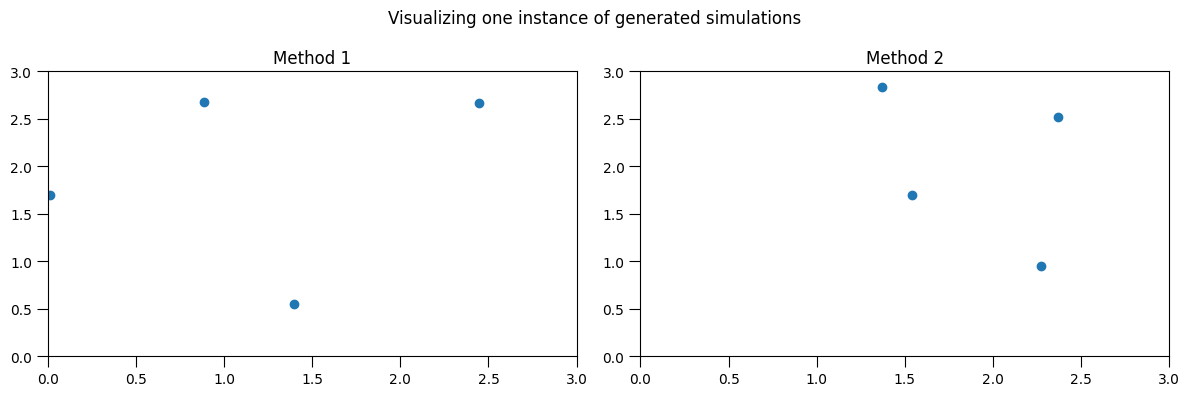

Exercise 6.2:


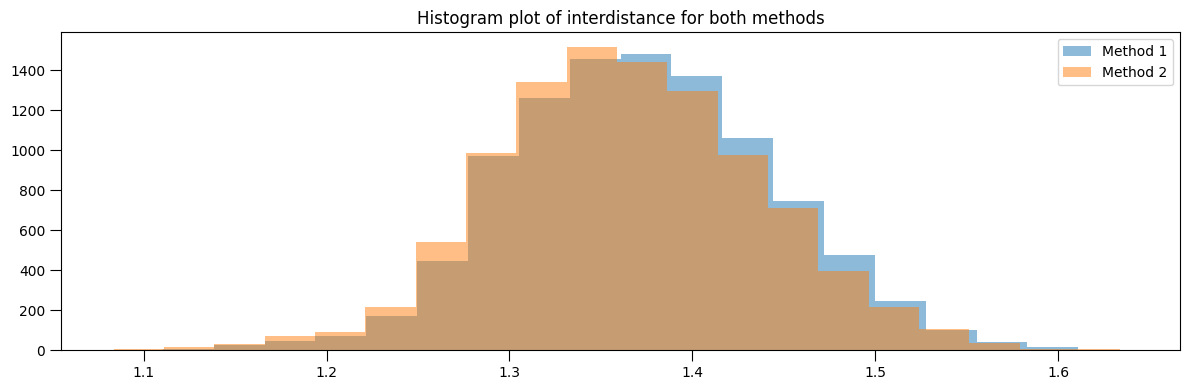

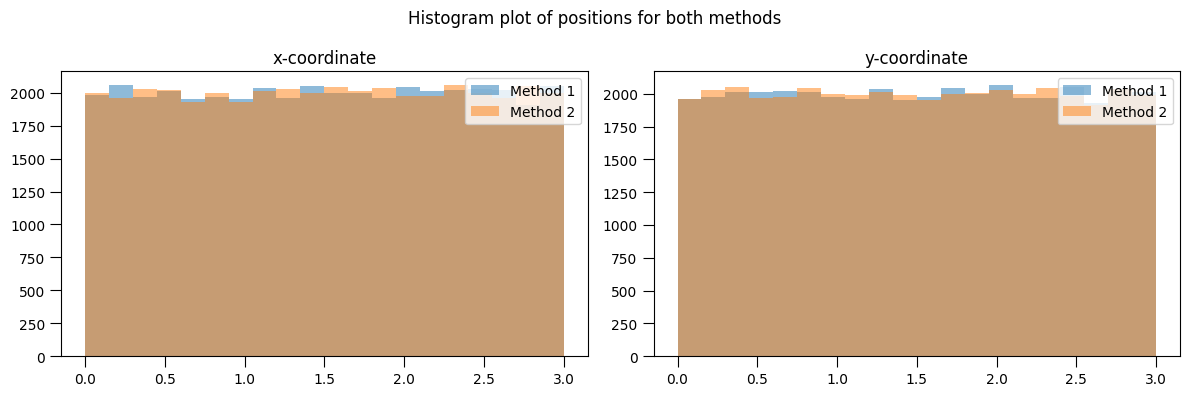

Exercise 6.3:


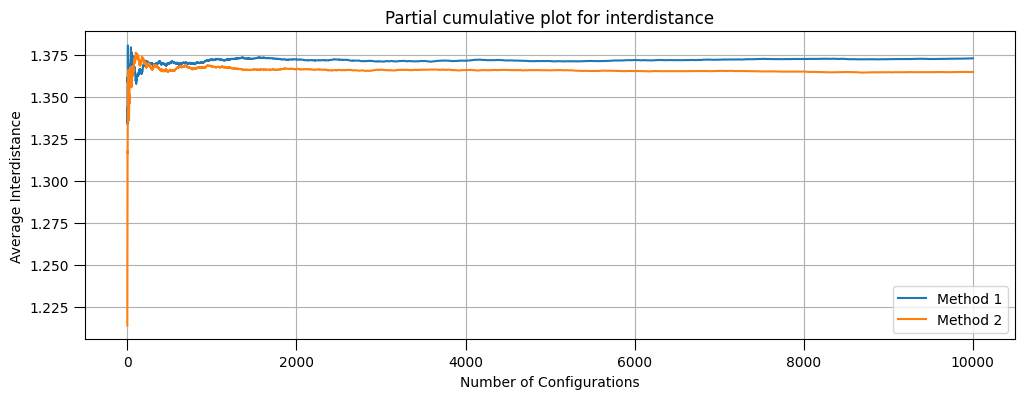

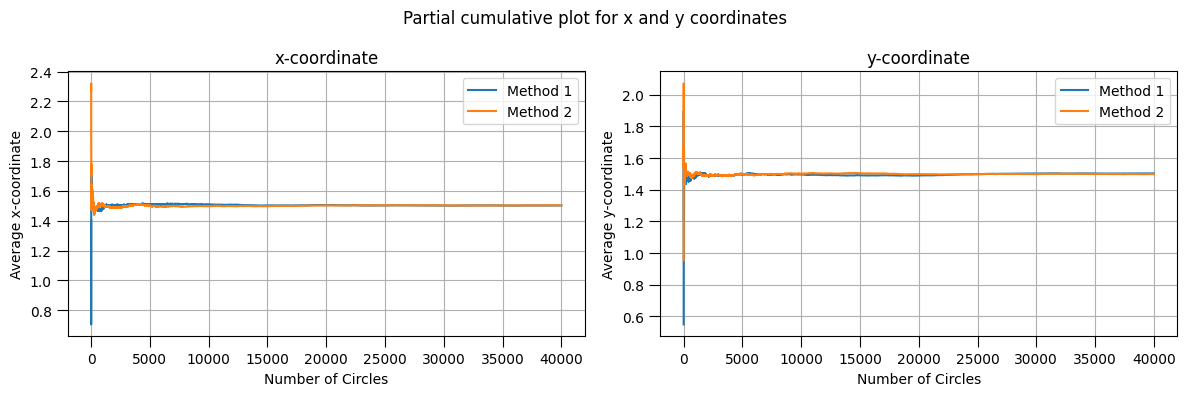

In [12]:
## Exercise 6 ##

M = 10000
N = 4
d = 2

sigma = 1
L = 3

simulation = periodic_hard_sphere(N,d,sigma,L)

## Plot similar to Exercise 6.1
print(" Exercise 6.1:")
# Generating configurations
configurations1 = np.zeros((M,N,d))
interdistance1 = np.zeros(M)

configurations2 = np.zeros((M,N,d))
interdistance2 = np.zeros(M)

for i in range(M):
    # Generating positions
    configurations1[i,:,:] = np.array(simulation.rejection_sampling_1())
    configurations2[i,:,:] = np.array(simulation.rejection_sampling_2())
    # Getting interdistances

    for j in range(N):
        for k in range(j):
            interdistance1[i] += simulation.get_periodic_distance(configurations1[i,j,:], configurations1[i,k,:])
            interdistance2[i] += simulation.get_periodic_distance(configurations2[i,j,:], configurations2[i,k,:])

    interdistance1[i] /= N * (N-1) / 2
    interdistance2[i] /= N * (N-1) / 2
    
# Visualizing one simulation
plt.figure(figsize=(12,4))
plt.suptitle("Visualizing one instance of generated simulations")

plt.subplot(1,2,1)
plt.title("Method 1")
x = configurations1[0,:,0]
y = configurations1[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.subplot(1,2,2)
plt.title("Method 2")
x = configurations2[0,:,0]
y = configurations2[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.tight_layout()
plt.show()

## Exercise 2
print("Exercise 6.2:")

# Histogram plot of interdistance for both methods
plt.figure(figsize=(12,4))
plt.title("Histogram plot of interdistance for both methods")
plt.hist(interdistance1, label='Method 1', alpha = 0.5, bins = 20)
plt.hist(interdistance2, label='Method 2', alpha = 0.5, bins = 20)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram plot for x and y coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot of positions for both methods")

# x-coordinate
plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.hist(configurations1[:,:,0].flatten(), alpha = 0.5, label='Method 1', bins = 20)
plt.hist(configurations2[:,:,0].flatten(), alpha = 0.5, label='Method 2', bins = 20)
plt.legend()

# y-coordinate
plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.hist(configurations1[:,:,1].flatten(), alpha = 0.5, label='Method 1', bins = 20)
plt.hist(configurations2[:,:,1].flatten(), alpha = 0.5, label='Method 2', bins = 20)
plt.legend()

plt.tight_layout()
plt.show()

## Exercise 3
print("Exercise 6.3:")

# Partial cumulative plot for interdistance
plt.figure(figsize=(12,4))
plt.title("Partial cumulative plot for interdistance")
plt.plot(np.cumsum(interdistance1) / np.arange(1, M + 1), label='Method 1')
plt.plot(np.cumsum(interdistance2) / np.arange(1, M + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Configurations")
plt.ylabel("Average Interdistance")
plt.grid(True)
plt.show()

# Partial cumulative plot for x-coordinate and y-coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Partial cumulative plot for x and y coordinates")

plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.plot(np.cumsum(configurations1[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Method 1')
plt.plot(np.cumsum(configurations2[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average x-coordinate")
plt.grid(True)

plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.plot(np.cumsum(configurations1[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Method 1')
plt.plot(np.cumsum(configurations2[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average y-coordinate")
plt.grid(True)

plt.tight_layout()
plt.show()

>  7. Do you have agreement betwee the two methods? 

Answer: Here we do not have agreement between the two methods. Since method 1 rejects spheres until a valid one is generated, it will tend to favor configurations where the centers are more spaced compared to the method 2. This is an important downside of method 1 that becomes an important factor when $L$ si small, close to the value of $\sigma$, hence when we reject more frequently. Method 2 is robust to this problem since it generates entire configurations at a time, therefore it does not have the bias that method 1 has.

From the plots obtained for both $L = 3$ and $L = 16$ we can conclude that:

- Method 2 delivers better results than method 1, however it is much slower since it restarts a configuration if a invalid circle appears.
- Method 1 can be the better choice when $L$ is large enough since colisions are less likely. However, in such situation, as colisions are less likely, method 2 should still deliver a configuration quickly.
- We remark that the histogram distribution of both the x and y coordinates remain unchanged, only the interdistance one is affected by the reduction of $L$. This is most likely due to the fact that we have periodic boundaries.

## 2) Adding hard walls

We consider now the stationary probability density for a configuration $x$ composed of the coordinates $(x_i)_i$ of $N$ spheres in dimension $d$ in a square box of size $L$ with **hard walls**: $$\pi(x) \propto \prod_{i=1}^N \left( \prod_{k=1}^d\mathbb{1}(x_{i,k} - \frac{\sigma}{2}>0)\mathbb{1}(x_{i,k} - L + \frac{\sigma}{2}<0)\prod_{j<i} \mathbb{1}(||x_i-x_j||_2 - \sigma > 0) \right)\, .$$

We set $d=2$, $N=4$, $\sigma=1$ and $L=3$. 

> 8. Create a class  ```hardwall_hard_sphere```  to simulate a system of spheres within hard walls in two dimensions, adapting the class for the periodic case.
> 9. Sample with both rejection methods 10000 configurations. Output the same histograms of interdistance and coordinates as previously done.

In [6]:
class hardwall_hard_sphere:
    def __init__(self,N=4, d=2, sigma=1.0, L = 16):
        # Parameter initialization
        self.N = N #number of spheres
        self.d = d #dimension of box
        self.sigma = sigma #sphere diameter
        self.L = L #length of square box
    
    def get_periodic_distance(self, x_1,x_2):        
        delta_x = x_1-x_2
        diff_x_periodic = min(abs(delta_x[0]),self.L-abs(delta_x[0]))
        diff_y_periodic = min(abs(delta_x[1]),self.L-abs(delta_x[1]))
        d_sq = diff_x_periodic ** 2.0 + diff_y_periodic ** 2.0
        return d_sq**0.5
    
    def pair_overlap_check(self,x_1, x_2):
        d = self.get_periodic_distance(x_1,x_2)
        if d < self.sigma:
            return True  #There is an overlap          
        return False
    
    def generate_sphere_position(self):
        # Generate directly the circle uniformly on the allowed region
        x_i_new = np.random.uniform(self.sigma/2, self.L - self.sigma/2, size=2)
        return x_i_new
        
    def rejection_sampling_1(self):
        x = []
        while len(x) < self.N:
            overlapping_proposition = True
            while overlapping_proposition:
                x_i_new = self.generate_sphere_position()
                overlapping_proposition = False
                for x_j in x:
                    if self.pair_overlap_check(x_j,x_i_new):
                        overlapping_proposition = True
                        break
            x += [x_i_new]
        return x
    
       
    def rejection_sampling_2(self):                    
        x = []
        while  len(x) < self.N:
            while len(x) < self.N:
                x_i_new = self.generate_sphere_position()
                overlapping_proposition = False
                for x_j in x:
                    if self.pair_overlap_check(x_j,x_i_new):
                        overlapping_proposition = True
                        break
                if overlapping_proposition:
                    x = []
                    break
                x += [x_i_new]
        return x    
   

Exercise 9.1:


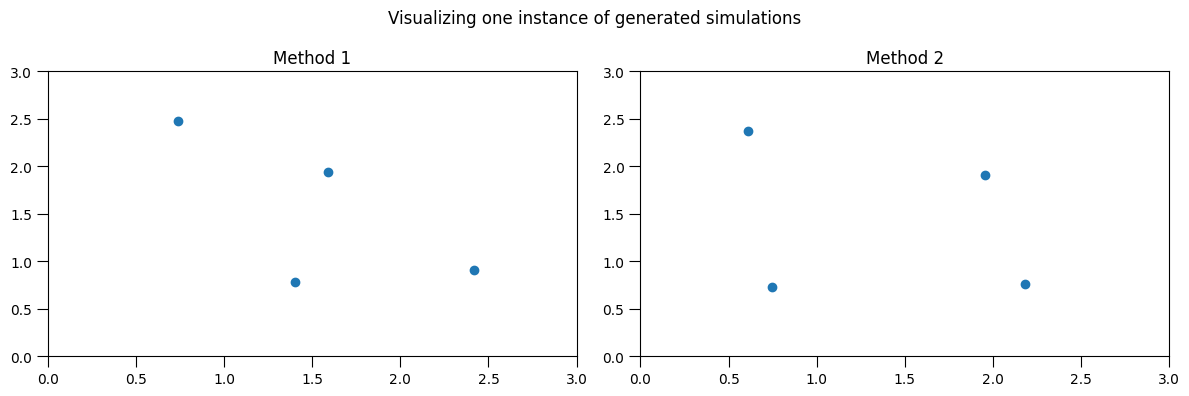

Exercise 9.2:


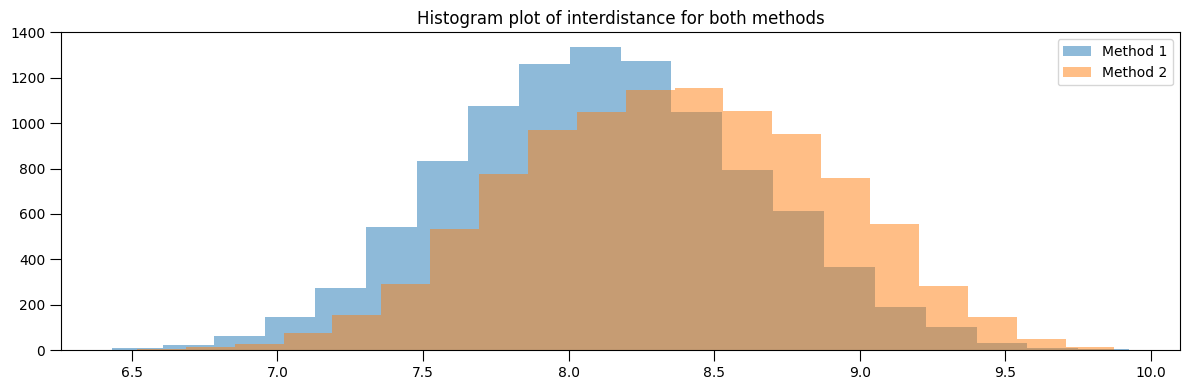

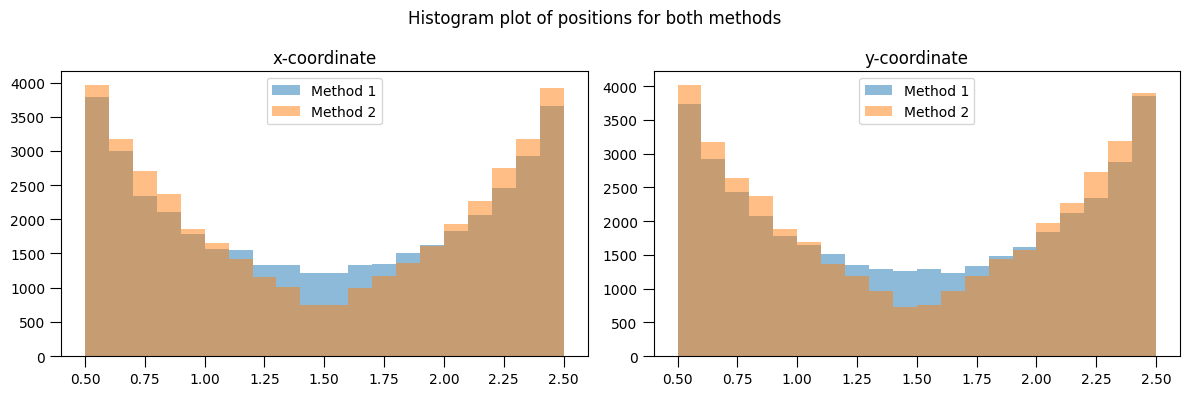

Exercise 9.3:


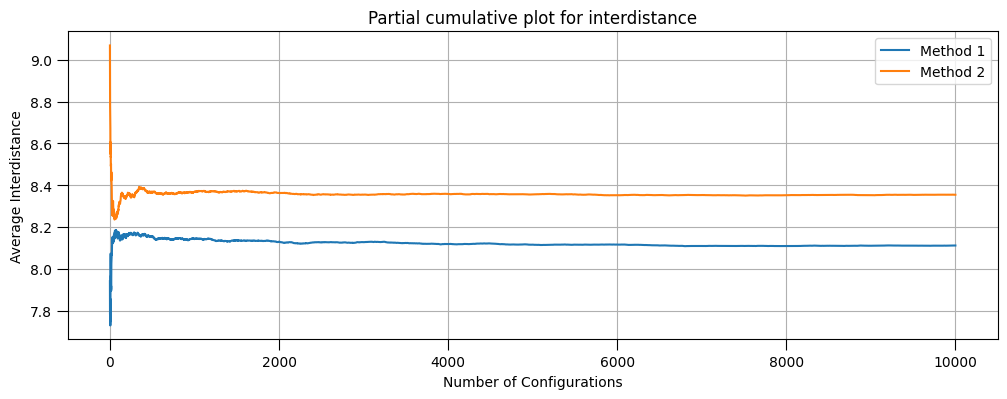

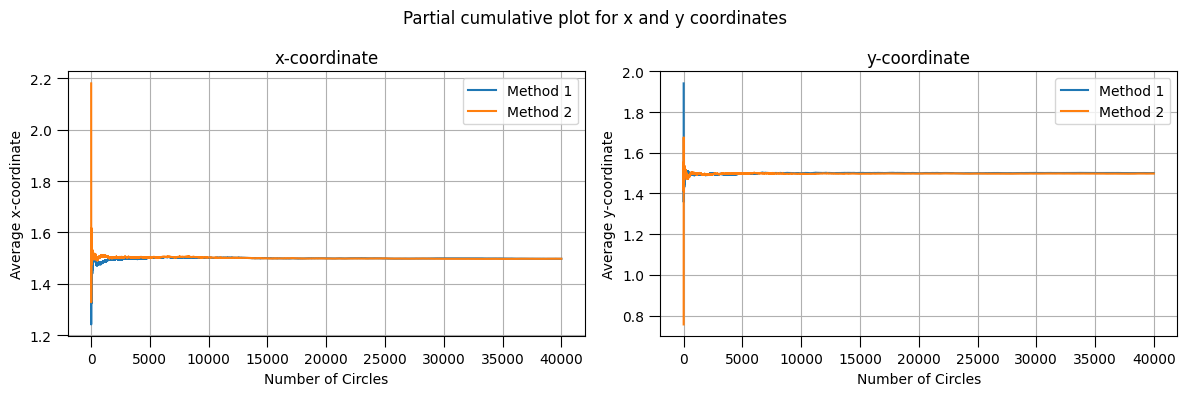

In [7]:
# Exercise 9

M = 10000
N = 4
d = 2

sigma = 1
L = 3

simulation = hardwall_hard_sphere(N,d,sigma,L)

## Exercise 1
print("Exercise 9.1:")
# Generating configurations
configurations1 = np.zeros((M,N,d))
interdistance1 = np.zeros(M)

configurations2 = np.zeros((M,N,d))
interdistance2 = np.zeros(M)

for i in range(M):
    # Generating positions
    configurations1[i,:,:] = np.array(simulation.rejection_sampling_1())
    configurations2[i,:,:] = np.array(simulation.rejection_sampling_2())
    # Getting interdistances

    for j in range(N):
        for k in range(j):
            interdistance1[i] += simulation.get_periodic_distance(configurations1[i,j,:], configurations1[i,k,:])
            interdistance2[i] += simulation.get_periodic_distance(configurations2[i,j,:], configurations2[i,k,:])

    interdistance1[i] /= N * (N-1) / 2
    interdistance2[i] /= N * (N-1) / 2
    
# Visualizing one simulation
plt.figure(figsize=(12,4))
plt.suptitle("Visualizing one instance of generated simulations")

plt.subplot(1,2,1)
plt.title("Method 1")
x = configurations1[0,:,0]
y = configurations1[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.subplot(1,2,2)
plt.title("Method 2")
x = configurations2[0,:,0]
y = configurations2[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.tight_layout()
plt.show()

## Exercise 2
print("Exercise 9.2:")

# Histogram plot of interdistance for both methods
plt.figure(figsize=(12,4))
plt.title("Histogram plot of interdistance for both methods")
plt.hist(interdistance1, label='Method 1', alpha = 0.5, bins = 20)
plt.hist(interdistance2, label='Method 2', alpha = 0.5, bins = 20)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram plot for x and y coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot of positions for both methods")

# x-coordinate
plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.hist(configurations1[:,:,0].flatten(), alpha = 0.5, label='Method 1', bins = 20)
plt.hist(configurations2[:,:,0].flatten(), alpha = 0.5, label='Method 2', bins = 20)
plt.legend()

# y-coordinate
plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.hist(configurations1[:,:,1].flatten(), alpha = 0.5, label='Method 1', bins = 20)
plt.hist(configurations2[:,:,1].flatten(), alpha = 0.5, label='Method 2', bins = 20)
plt.legend()

plt.tight_layout()
plt.show()

## Exercise 3
print("Exercise 9.3:")

# Partial cumulative plot for interdistance
plt.figure(figsize=(12,4))
plt.title("Partial cumulative plot for interdistance")
plt.plot(np.cumsum(interdistance1) / np.arange(1, M + 1), label='Method 1')
plt.plot(np.cumsum(interdistance2) / np.arange(1, M + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Configurations")
plt.ylabel("Average Interdistance")
plt.grid(True)
plt.show()

# Partial cumulative plot for x-coordinate and y-coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Partial cumulative plot for x and y coordinates")

plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.plot(np.cumsum(configurations1[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Method 1')
plt.plot(np.cumsum(configurations2[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average x-coordinate")
plt.grid(True)

plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.plot(np.cumsum(configurations1[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Method 1')
plt.plot(np.cumsum(configurations2[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average y-coordinate")
plt.grid(True)

plt.tight_layout()
plt.show()

> 10. Do you have agreement between the two methods? Is a method not correct?
> 11. Are both methods still correct in the periodic case though?
> 12. Comment the shape of the obtained stationary distribution of the x- and y-coordinates, for instance is it surprising it is not uniform anymore? (To go further: https://en.wikipedia.org/wiki/Depletion_force)
> 13. Redo the simulations for $L=16$, are the effects observed in $L=3$ also present here?

Answers:

**Exercise 10:**

We can see from the plots that the two methods **do not agree**:

- The main issue with method 1 is that it assumes that the first sphere can be sampled uniformly in the hard wall configuration. This is not true, and can be easily be visualized if we are in the case where $L$ is close to $\sigma$. In such configurations, a sphere first taken in the center will force a configuration that is less likely to occur. In order words, the position of the first sphere is not independant on the positions of the other ones.

- Method 2 is more robust since it works as if it selected all spheres "**at once**", not one by one. It therefore creates configurations that are indeed what we search in our Monte Carlo simulation.

- This is precisely what we observe in the **histogram plots**. Method 1 has more spheres at the center (histogram of x and y coordinates), while method 2 concentrates at the borders. Altough both methods converge, the method 2 is the one that correspond to the correct Monte Carlo simulation that we search. In terms of the interdistance, we should therefore use the plot of method 2 as the correct one.

It is interesting to remark that this time the interdistance of method 1 is smaller. This makes sense since when we take a sphere in the center it is more likely that the other spheres will be closer to each other, whereas in method 2 this is not the case.

**Exercise 11:**

TODO

**Exercise 12:**

As previously commented in Exercise 10, this is not surprising - a sphere in the center will block more surface area for new centers than at the border, making such configurations less likely to occur. Therefore, most of the time we will see circles that are more concentrated at the extremities of the square.

One might question that, since method 1 will still allow for the first circle to be generated at the center equally as likely to anywhere else, such effects should not occur. Altough this is true in the sense (we observe more instances of x and y coordinates at the center for method one), since such circles block an important area, the following ones will concentrate at the extremities.


Exercise 13.1:


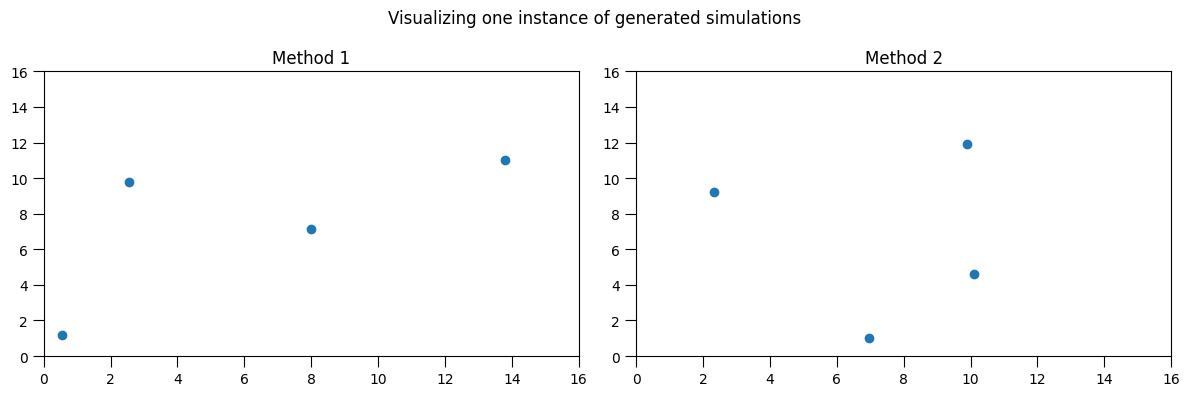

Exercise 13.2:


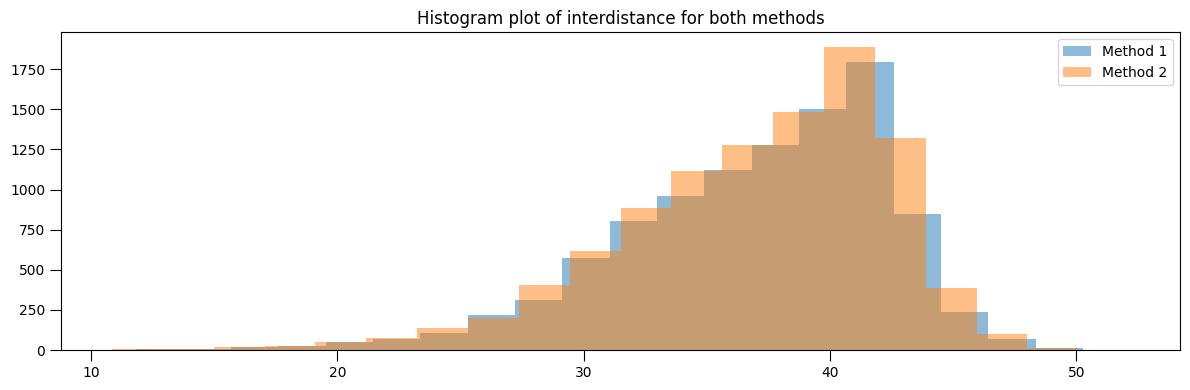

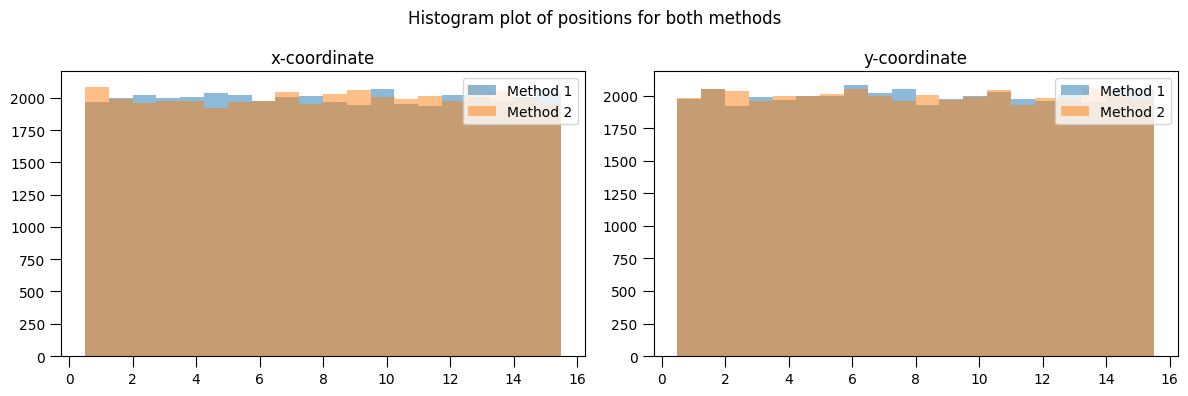

Exercise 13.3:


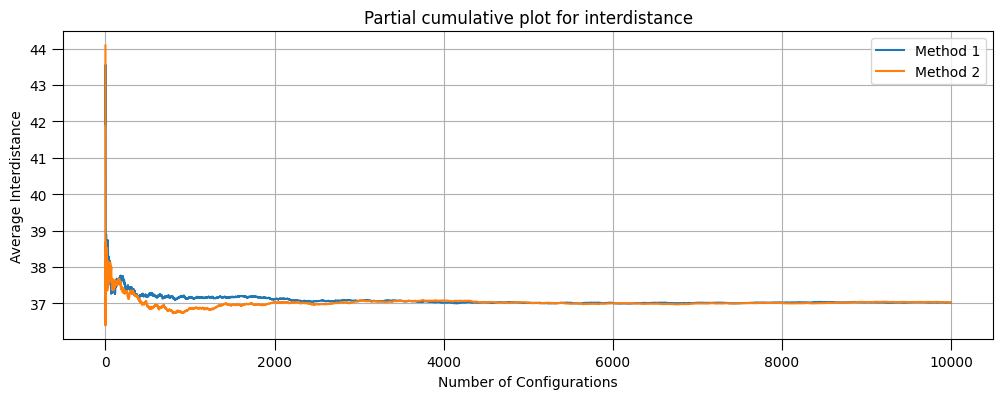

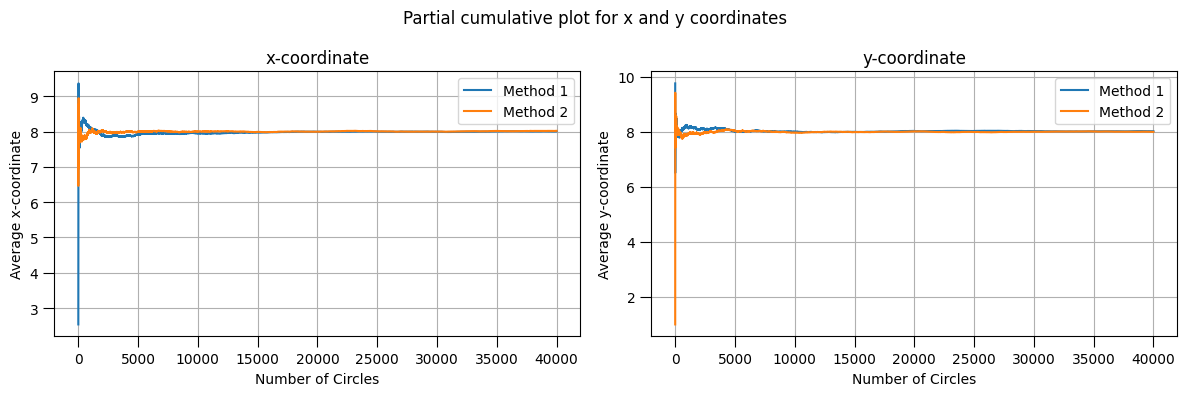

In [8]:
# Exercise 13

M = 10000
N = 4
d = 2

sigma = 1
L = 16

simulation = hardwall_hard_sphere(N,d,sigma,L)

## Exercise 1
print("Exercise 13.1:")
# Generating configurations
configurations1 = np.zeros((M,N,d))
interdistance1 = np.zeros(M)

configurations2 = np.zeros((M,N,d))
interdistance2 = np.zeros(M)

for i in range(M):
    # Generating positions
    configurations1[i,:,:] = np.array(simulation.rejection_sampling_1())
    configurations2[i,:,:] = np.array(simulation.rejection_sampling_2())
    # Getting interdistances

    for j in range(N):
        for k in range(j):
            interdistance1[i] += simulation.get_periodic_distance(configurations1[i,j,:], configurations1[i,k,:])
            interdistance2[i] += simulation.get_periodic_distance(configurations2[i,j,:], configurations2[i,k,:])

    # interdistance1[i] /= N * (N-1) / 2
    # interdistance2[i] /= N * (N-1) / 2
    
# Visualizing one simulation
plt.figure(figsize=(12,4))
plt.suptitle("Visualizing one instance of generated simulations")

plt.subplot(1,2,1)
plt.title("Method 1")
x = configurations1[0,:,0]
y = configurations1[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.subplot(1,2,2)
plt.title("Method 2")
x = configurations2[0,:,0]
y = configurations2[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.tight_layout()
plt.show()

## Exercise 2
print("Exercise 13.2:")

# Histogram plot of interdistance for both methods
plt.figure(figsize=(12,4))
plt.title("Histogram plot of interdistance for both methods")
plt.hist(interdistance1, label='Method 1', alpha = 0.5, bins = 20)
plt.hist(interdistance2, label='Method 2', alpha = 0.5, bins = 20)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram plot for x and y coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot of positions for both methods")

# x-coordinate
plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.hist(configurations1[:,:,0].flatten(), alpha = 0.5, label='Method 1', bins = 20)
plt.hist(configurations2[:,:,0].flatten(), alpha = 0.5, label='Method 2', bins = 20)
plt.legend()

# y-coordinate
plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.hist(configurations1[:,:,1].flatten(), alpha = 0.5, label='Method 1', bins = 20)
plt.hist(configurations2[:,:,1].flatten(), alpha = 0.5, label='Method 2', bins = 20)
plt.legend()

plt.tight_layout()
plt.show()

## Exercise 3
print("Exercise 13.3:")

# Partial cumulative plot for interdistance
plt.figure(figsize=(12,4))
plt.title("Partial cumulative plot for interdistance")
plt.plot(np.cumsum(interdistance1) / np.arange(1, M + 1), label='Method 1')
plt.plot(np.cumsum(interdistance2) / np.arange(1, M + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Configurations")
plt.ylabel("Average Interdistance")
plt.grid(True)
plt.show()

# Partial cumulative plot for x-coordinate and y-coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Partial cumulative plot for x and y coordinates")

plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.plot(np.cumsum(configurations1[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Method 1')
plt.plot(np.cumsum(configurations2[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average x-coordinate")
plt.grid(True)

plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.plot(np.cumsum(configurations1[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Method 1')
plt.plot(np.cumsum(configurations2[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average y-coordinate")
plt.grid(True)

plt.tight_layout()
plt.show()

Comments on plots of **Exercise 13**: 

- We remark that the border effects that happened when $L=3$ are no longer present when $L=16$: x-coordinate and y-coordinate are rather uniform, and interdistance is fairly **similar** to the one of the previous exercises when borders are periodic (of course not the same since circles cannot occupy for example $x\in[0,\frac{\sigma}{2})$). When $L=3$, a circle in the center created an important invalid zone for new circles: such configurations were therefore less likely. Now, when $L=16$, such effects mostly disapear since there is enough space for all circles to even be generated iteratively such as in method one without having to reject samples.
- We also remark that results from both methods 1 and 2 are fairly similar, which was not the case before. This makes sense, since when colisions are not that often, method 1 will create all circles of a given configuration without having to reject often, doing almost the same thing as method 2.

## 3) Markov-Chain Monte Carlo

We now consider a sampling based on a Markov chain for the hard-wall case which is defined as follows for $\delta >0$.
Given the current point $X^k= (X_i^k)_{i=1}^N \in \mathbb{R}^{d\times N}$:
- a) Sample from $i^{k+1} \in \{1,\ldots,N\}$ uniformly 
- b) Propose $Y^{k+1}_{i^{k+1}} = X^k_{i^{k+1}} + \delta Z^{k+1}$ where $Z^{k+1} \sim \mathrm{N}(0,\delta^2 \mathrm{Id})$ is independent from the past, and $Y^{k+1}_i = X^{k+1}_i$ for $i \neq i^{k+1}$.
- c) Set $X^{k+1}$ from $X^k$ and $Y^{k+1}$ using the Metropolis-Hastings accept-reject step seen in course.

> 14. Complete the class ```hardwall_hard_sphere``` to include a routine producing samples obtained by a Markov-chain Monte Carlo method. For instance, consider a Metropolis-like scheme with a Markov kernel proposing to move a single random sphere by a small Gaussian increment ($\mathcal{N}(0,\delta^2)$) each time.
> 15. For $N=4, L=3$, generate 10000 samples by the Markov-chain and rejection sampling scheme of your choice. Output also the averaged acceptance rates of the reject sampling and Markov-chain sampling scheme. Compare the obtained histograms of the interdistance between spheres and of the x- and y-coordinates of spheres.
> 16. What can you say about the apparent speed of convergence of both methods? Take into account the acceptance rates and the number of moved spheres between successive configurations in your analysis.
> 17. For $N=4, L =2.5$, redo the simulations (you can choose to generate only 1000 configurations). What can you say about the acceptance rates of both methods? How did you choose the $\delta$ value?
> 18. Comment the stationary distribution for a sphere position.

In [91]:
class hardwall_hard_sphere:
    def __init__(self,N=4, d=2, sigma=1.0, L = 16):
        # Parameter initialization
        self.N = N #number of spheres
        self.d = d #dimension of box
        self.sigma = sigma #sphere diameter
        self.L = L #length of square box
    
    def get_periodic_distance(self, x_1,x_2):        
        delta_x = x_1-x_2
        diff_x_periodic = min(abs(delta_x[0]),self.L-abs(delta_x[0]))
        diff_y_periodic = min(abs(delta_x[1]),self.L-abs(delta_x[1]))
        d_sq = diff_x_periodic ** 2.0 + diff_y_periodic ** 2.0
        return d_sq**0.5
    
    def pair_overlap_check(self,x_1, x_2):
        d = self.get_periodic_distance(x_1,x_2)
        if d < self.sigma:
            return True  #There is an overlap          
        return False
    
    def generate_sphere_position(self):
        # Generate directly the circle uniformly on the allowed region
        x_i_new = np.random.uniform(self.sigma/2, self.L - self.sigma/2, size=2)
        return x_i_new
    
    def rejection_sampling_metropolis(self, M, delta):
        configurations = np.zeros((M, self.N, self.d))
        
        # Generate first instance
        configurations[0,:,:] = self.rejection_sampling_2()
        
        for i in range(1,M):
            # Generating positions
            configurations[i,:,:] = configurations[i-1,:,:]
            
            i_k1 = np.random.randint(0, self.N)
            new_sphere = configurations[i,i_k1,:] + np.random.normal(0, delta, self.d)
            
            valid = True
            for id_sphere in range(N):
                if id_sphere == i_k1:
                    for coordinate in range(self.d):
                        if new_sphere[coordinate] < self.sigma/2 or new_sphere[coordinate] > self.L - self.sigma/2:
                            valid = False
                            break
                else:
                    valid = valid and not self.pair_overlap_check(new_sphere, configurations[i,id_sphere,:])
                    if not valid: break
                    
            if valid:
                configurations[i,i_k1,:] = new_sphere
                
        return configurations
        
    def rejection_sampling_1(self):
        x = []
        while len(x) < self.N:
            overlapping_proposition = True
            while overlapping_proposition:
                x_i_new = self.generate_sphere_position()
                overlapping_proposition = False
                for x_j in x:
                    if self.pair_overlap_check(x_j,x_i_new):
                        overlapping_proposition = True
                        break
            x += [x_i_new]
        return x
    
       
    def rejection_sampling_2(self):                    
        x = []
        while  len(x) < self.N:
            while len(x) < self.N:
                x_i_new = self.generate_sphere_position()
                overlapping_proposition = False
                for x_j in x:
                    if self.pair_overlap_check(x_j,x_i_new):
                        overlapping_proposition = True
                        break
                if overlapping_proposition:
                    x = []
                    break
                x += [x_i_new]
        return x    

Exercise 13.1:


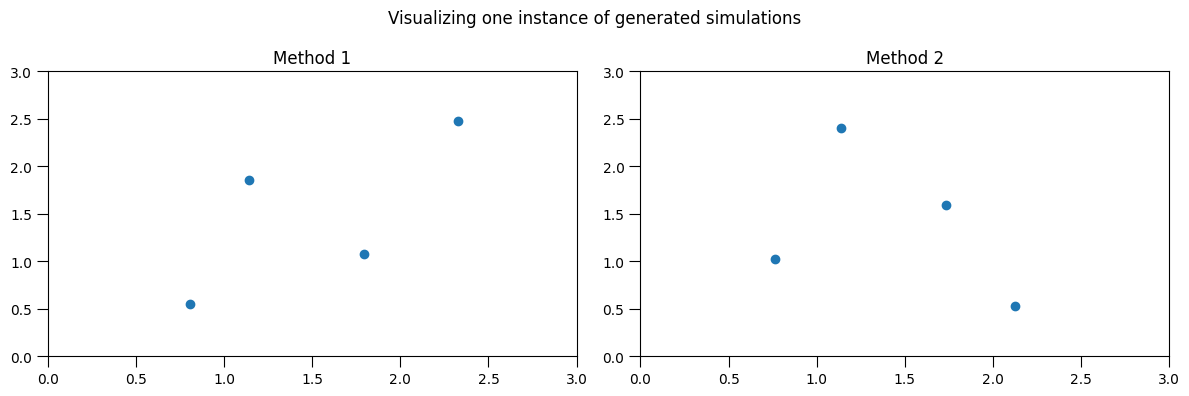

Exercise 13.2:


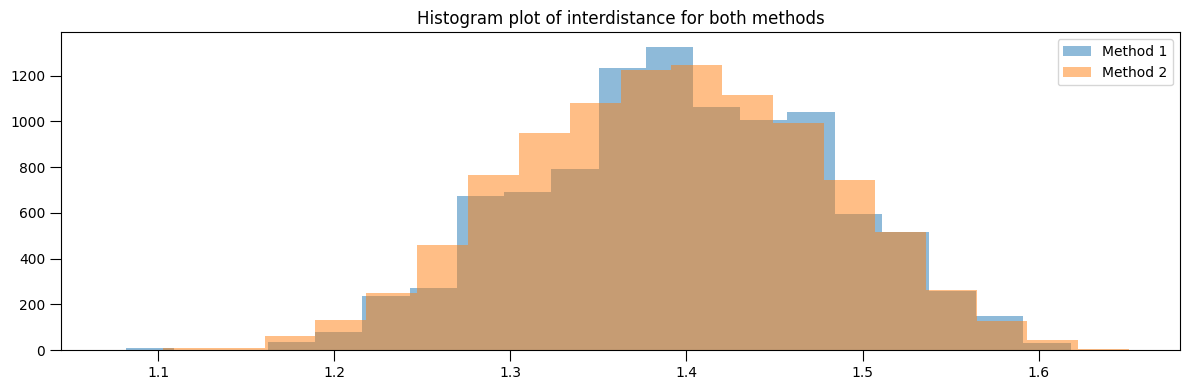

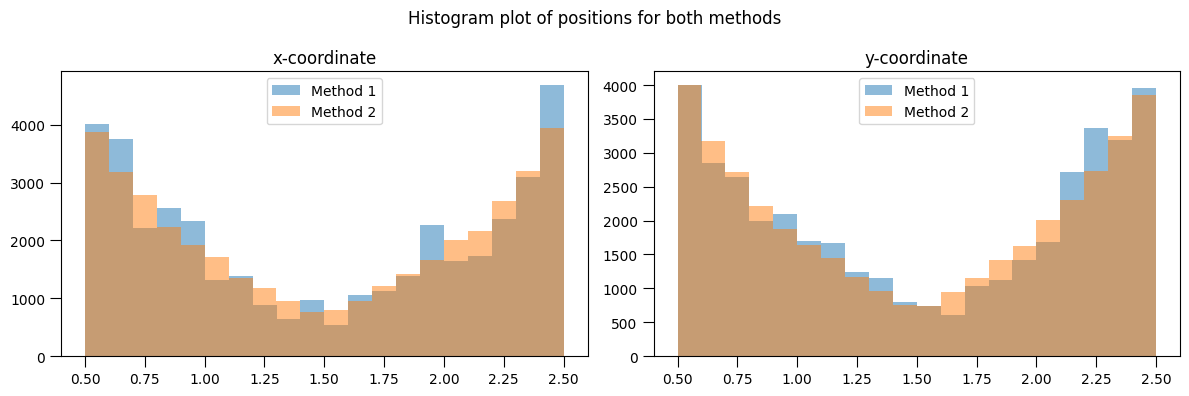

Exercise 13.3:


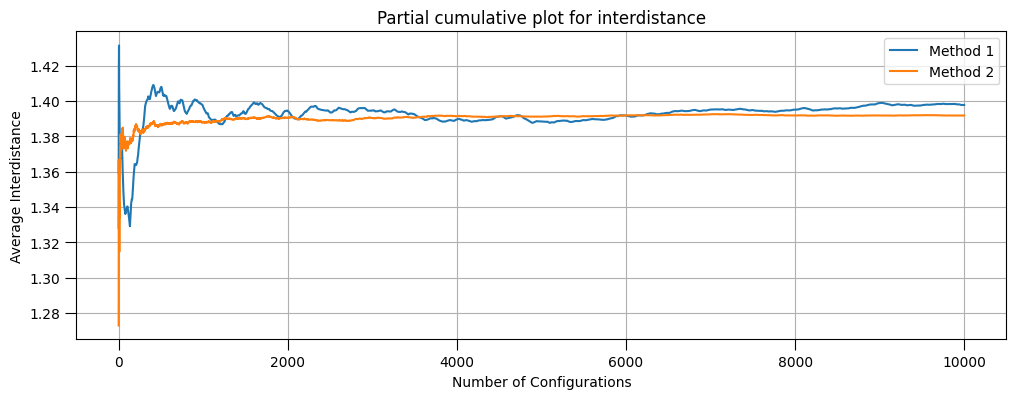

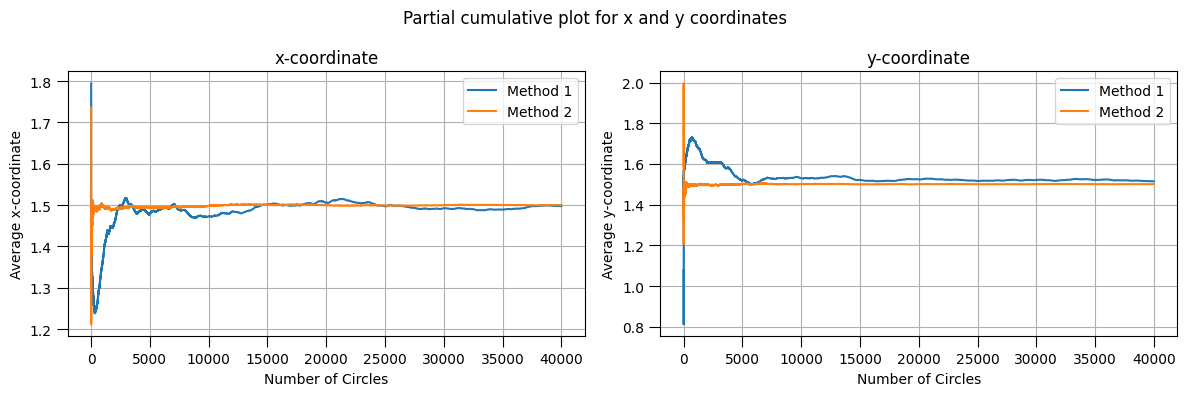

In [93]:
# Exercise 13

M = 10000
N = 4
d = 2

sigma = 1
L = 3
delta = 0.5

simulation = hardwall_hard_sphere(N,d,sigma,L)

## Exercise 1
print("Exercise 13.1:")
# Generating configurations
configurations1 = np.zeros((M,N,d))
interdistance1 = np.zeros(M)

configurations2 = np.zeros((M,N,d))
interdistance2 = np.zeros(M)

configurations1 = simulation.rejection_sampling_metropolis(M, delta)

for i in range(M):
    # Generating positions
    configurations2[i,:,:] = np.array(simulation.rejection_sampling_2())
    # Getting interdistances

    for j in range(N):
        for k in range(j):
            interdistance1[i] += simulation.get_periodic_distance(configurations1[i,j,:], configurations1[i,k,:])
            interdistance2[i] += simulation.get_periodic_distance(configurations2[i,j,:], configurations2[i,k,:])

    interdistance1[i] /= N * (N-1) / 2
    interdistance2[i] /= N * (N-1) / 2
    
# Visualizing one simulation
plt.figure(figsize=(12,4))
plt.suptitle("Visualizing one instance of generated simulations")

plt.subplot(1,2,1)
plt.title("Method 1")
x = configurations1[0,:,0]
y = configurations1[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.subplot(1,2,2)
plt.title("Method 2")
x = configurations2[0,:,0]
y = configurations2[0,:,1]
plt.scatter(x,y)
plt.xlim(0,simulation.L)
plt.ylim(0,simulation.L)

plt.tight_layout()
plt.show()

## Exercise 2
print("Exercise 13.2:")

# Histogram plot of interdistance for both methods
plt.figure(figsize=(12,4))
plt.title("Histogram plot of interdistance for both methods")
plt.hist(interdistance1, label='Method 1', alpha = 0.5, bins = 20)
plt.hist(interdistance2, label='Method 2', alpha = 0.5, bins = 20)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram plot for x and y coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Histogram plot of positions for both methods")

# x-coordinate
plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.hist(configurations1[:,:,0].flatten(), alpha = 0.5, label='Method 1', bins = 20)
plt.hist(configurations2[:,:,0].flatten(), alpha = 0.5, label='Method 2', bins = 20)
plt.legend()

# y-coordinate
plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.hist(configurations1[:,:,1].flatten(), alpha = 0.5, label='Method 1', bins = 20)
plt.hist(configurations2[:,:,1].flatten(), alpha = 0.5, label='Method 2', bins = 20)
plt.legend()

plt.tight_layout()
plt.show()

## Exercise 3
print("Exercise 13.3:")

# Partial cumulative plot for interdistance
plt.figure(figsize=(12,4))
plt.title("Partial cumulative plot for interdistance")
plt.plot(np.cumsum(interdistance1) / np.arange(1, M + 1), label='Method 1')
plt.plot(np.cumsum(interdistance2) / np.arange(1, M + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Configurations")
plt.ylabel("Average Interdistance")
plt.grid(True)
plt.show()

# Partial cumulative plot for x-coordinate and y-coordinate
plt.figure(figsize=(12,4))
plt.suptitle("Partial cumulative plot for x and y coordinates")

plt.subplot(1,2,1)
plt.title("x-coordinate")
plt.plot(np.cumsum(configurations1[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Method 1')
plt.plot(np.cumsum(configurations2[:,:,0].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average x-coordinate")
plt.grid(True)

plt.subplot(1,2,2)
plt.title("y-coordinate")
plt.plot(np.cumsum(configurations1[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Method 1')
plt.plot(np.cumsum(configurations2[:,:,1].flatten()) / np.arange(1, M*N + 1), label='Method 2')
plt.legend()
plt.xlabel("Number of Circles")
plt.ylabel("Average y-coordinate")
plt.grid(True)

plt.tight_layout()
plt.show()

## The following are **optional questions**

> 19. Complete the class ```periodic_hard_sphere``` to include a routine producing samples obtained by a Markov-chain Monte Carlo method similar to the previously coded one.
> 15. For $N=4, L=2.5$ generate 10000 samples by the Markov-chain and rejection sampling scheme of your choice. Output also the averaged acceptance rates of the reject sampling and Markov-chain sampling scheme. Compare the obtained histograms of the interdistance between spheres and of the x- and y-coordinates of spheres. 
> 16. What can you say about the apparent speed of convergence and acceptance rates of both methods compared to the hardwall case? Is it surprising?